In [15]:
import numpy as np
from numpy.lib.function_base import quantile
import pandas as pd
from datetime import datetime
np.set_printoptions(suppress=True)

looking_period = 1
lag = 1
holding_period = 1
quantile_step = 0.2
liquidity_threshold = 100_000_000 
fee_rate= 0.0005

Download data from YF for simplicity. In general, it is better to use data sets with full market coverage.

In [3]:
stock_list = ['AAPL', 'FB', 'NFLX', 'GOOG', 'AMZN', 'DAL', 'GE', 'XOM', 'F', 'WFC']
start_date = datetime(2016,1,1) # YYYY-MM-DD
end_date = datetime(2021,4,30)

import pandas_datareader.data as web

stocks_request = web.DataReader(stock_list, 'yahoo', start_date, end_date)
stocks_price = pd.DataFrame(stocks_request['Adj Close'])
monthly_price = stocks_price.resample(rule='M').last()

stocks_volume = pd.DataFrame(stocks_request['Volume'])
stocks_volume *= stocks_price
monthly_volume = stocks_volume.resample(rule='M').mean()

price = monthly_price.values
volume = monthly_volume.values
dates = np.array(monthly_price.index)

In [6]:
monthly_price.head()

Symbols,AAPL,FB,NFLX,GOOG,AMZN,DAL,GE,XOM,F,WFC
Date,,,,,,,,,,
2016-01-31,22.473866,112.209999,91.839996,742.950012,587.000000,40.251656,25.274879,60.439861,9.398948,42.271030
2016-02-29,22.444927,106.919998,93.410004,697.770020,552.520020,43.980537,25.512241,62.790276,9.847643,39.791092
2016-03-31,25.300169,114.099998,102.230003,744.950012,593.640015,44.381695,27.832335,65.485214,10.626953,41.012295
2016-04-30,21.760138,117.580002,90.029999,693.010010,659.590027,37.990654,26.921810,69.253410,10.791914,42.386158
2016-05-31,23.321924,118.809998,102.570000,735.719971,722.789978,39.750244,26.466545,70.325218,10.736203,43.343140


Prepare prices for testing the Momentum factor

In [7]:
from pqr.data_preprocessing import get_factor

momentum_factor = get_factor(price, static=False, looking_period=looking_period, lag=lag)

We will remove illiquid stocks from the sample. Obviously, there are no such stocks in this selection. But if you work with penny stocks or EM, it makes sense.

Trading volume filter as an example. You can use any other indicator. For example, high Net Debt/EBITDA.

In [8]:
from pqr.data_preprocessing import set_stock_universe

momentum_factor = set_stock_universe(momentum_factor, volume, min_threshold=liquidity_threshold)

Construct 5 portfolios of 20% quantiles from the smallest Momentum to the largest.

In [9]:
from pqr.portfolios_formation import get_all_quantiles

momentum_positions, momentum_names = get_all_quantiles(momentum_factor, quantile_step=quantile_step,
                                                       holding_period=holding_period, static=False)

C:\Users\tomtosov\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


Equal weights or 2 stocks in each portfolio.

In [10]:
from pqr.portfolios_formation import set_equal_weights

momentum_portfolio = set_equal_weights(momentum_positions)

C:\Users\tomtosov\Desktop\pqr\pqr\portfolios_formation.py:137: RuntimeWarning: invalid value encountered in true_divide
  portfolio_weights.append(positions_lists[i] / positions_sum[:,None])


Fee costs per trade.

In [11]:
from pqr.costs import get_fee_costs

fee = get_fee_costs(momentum_portfolio, fee_rate=fee_rate)

Portfolio position return.

In [12]:
from pqr.portfolio_return import get_universe_return
from pqr.portfolio_return import get_portfolio_return

universe_return = get_universe_return(price)
momentum_portfolio_return = get_portfolio_return(momentum_portfolio, universe_return, fee_lists=fee)

Construct benchmark + plot + ratios

In [13]:
from pqr.portfolio_return import compare_portfolios
from pqr.benchmark import get_benchmark

benchmark_return = get_benchmark(price, momentum_factor, universe_return, equal_weights=True)

C:\Users\tomtosov\Desktop\pqr\pqr\portfolios_formation.py:133: RuntimeWarning: invalid value encountered in true_divide
  portfolio_weights = positions_lists / positions_sum[:,None]


╒════════════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╤════════════════╕
│                │   quantile_20 │   quantile_40 │   quantile_60 │   quantile_80 │   quantile_100 │
╞════════════════╪═══════════════╪═══════════════╪═══════════════╪═══════════════╪════════════════╡
│ Alpha %        │         -0.92 │         -1.19 │         -0.07 │          0.92 │           1.14 │
├────────────────┼───────────────┼───────────────┼───────────────┼───────────────┼────────────────┤
│ Alpha t        │         -1.39 │         -1.94 │         -0.13 │          1.43 │           1.91 │
├────────────────┼───────────────┼───────────────┼───────────────┼───────────────┼────────────────┤
│ SR             │          0.29 │          0.15 │          0.64 │          1.09 │           1.24 │
├────────────────┼───────────────┼───────────────┼───────────────┼───────────────┼────────────────┤
│ MR %           │          0.68 │          0.34 │          1.18 │          2.27 │           2.49 │


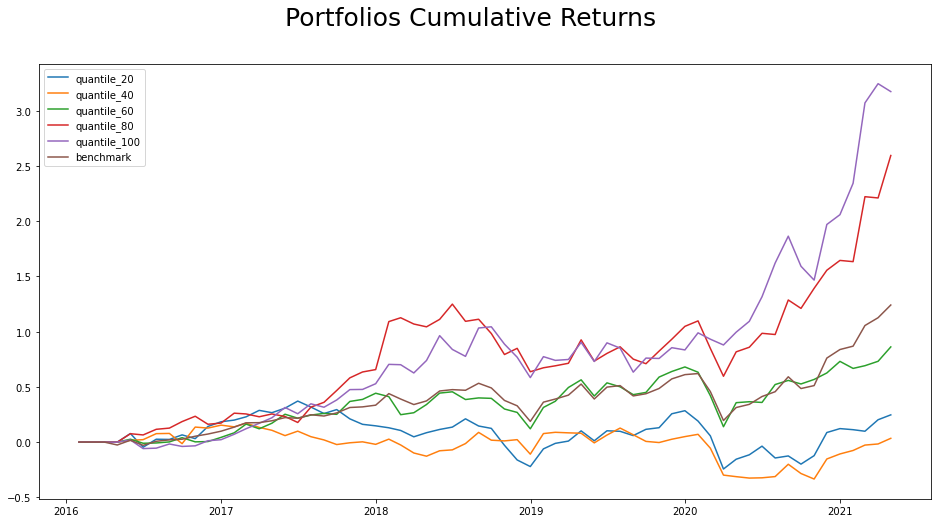

In [14]:
momentum_results = compare_portfolios(momentum_names, momentum_portfolio_return, benchmark_return, dates)